In [157]:
import numpy as np
from scipy import signal
import sympy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [158]:
%matplotlib notebook

In [159]:
data = np.genfromtxt('voltage_omega.dat')
T = data[:,0]
V = data[:,2]
W = data[:,1]
N = np.size(T)
def func_v(t, a, b, c, d):
    return c + a* np.exp(-b * t) + d*t

idt = np.argmax(T>1.0)
popt_v, pcov = curve_fit(func_v, T[idt:], V[idt:])
V_ini = V[0]
V_end = V[-1]
DV = popt_v[2] - V_ini
tau = 1/popt_v[1]

In [160]:
print(f'tau = {tau:0.2f} s')

tau = 0.99 s


<IPython.core.display.Javascript object>


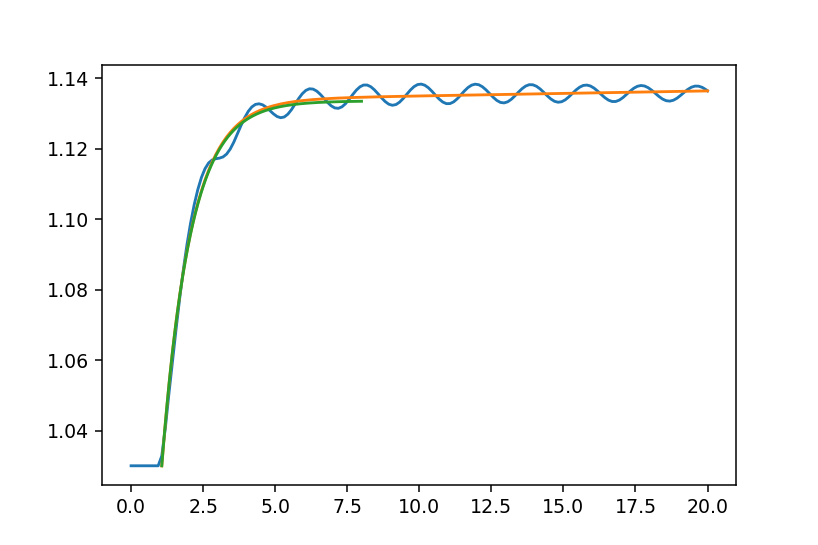

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex = True)

axes.plot(T,V)
a, b, c, d = popt_v
axes.plot(T[idt:],func_v(T[idt:], a, b, c, d))

num = [1]
den = [tau , 1]
G_avr = signal.TransferFunction(num, den)
T_avr,Y_avr = signal.step(G_avr, N=1000)
axes.plot(T_avr+T[idt],DV*Y_avr+V_ini)


In [163]:
Tau_avr = tau
freq = 0.5
T_wo = 10.0

### AVR phase for given frequency

In [188]:
w_avr, mag_avr, phase_avr = signal.bode(G_avr, freq*2*np.pi)
print(f'For the given frequency the AVR has {phase_avr[0]:0.2f} deg. of phase')

For the given frequency the AVR has -72.18 deg. of phase


In [189]:

num_wo = [ T_wo, 0]
den_wo = [T_wo, 1]
G_wo = signal.TransferFunction(num_wo, den_wo)

w_wo, mag_wo, phase_wo = signal.bode(G_wo, freq*2*np.pi)
print(f'For the given frequency the Washout-Filter has {phase_wo[0]:0.2f} deg. of phase')


For the given frequency the Washout-Filter has 1.82 deg. of phase


In [190]:
sin_phi = -np.sin(np.deg2rad(phase_avr+phase_wo))
w_m = 2.0*np.pi*freq

a = -(sin_phi + 1)/(sin_phi - 1)
T_lead =  1/(w_m*np.sqrt((-sin_phi - 1)/(sin_phi - 1)))

T_1 = a*T_lead
T_2 = T_lead

G_lead = signal.TransferFunction([float(T_1),1], [float(T_2),1])

In [191]:
w_lead, mag_lead, phase_lead = signal.bode(G_lead, freq*2*np.pi)
print(f'For the input frequency the AVR has {phase_lead[0]:0.2f} deg. of phase \nand {mag_lead[0]:0.2f} of gain')

For the input frequency the AVR has 70.35 deg. of phase 
and 15.23 of gain


In [192]:
omegas = np.linspace(0.1,2*np.pi*10,500)
w_avr, mag_avr, phase_avr = signal.bode(G_avr,omegas)
w_lead, mag_lead, phase_lead = signal.bode(G_lead,omegas)
w_wo, mag_wo, phase_wo = signal.bode(G_wo,omegas)

In [195]:
num_pss = np.polymul(G_wo.num,G_lead.num)
den_pss = np.polymul(G_wo.den,G_lead.den) 
G_pss = signal.TransferFunction(num_pss, den_pss)

num_sys = np.polymul(G_pss.num,G_avr.num)
den_sys = np.polymul(G_pss.den,G_avr.den) 
G_sys = signal.TransferFunction(num_sys, den_sys)

w_pss, mag_pss, phase_pss = signal.bode(G_pss,omegas)
w_sys, mag_sys, phase_sys = signal.bode(G_sys,omegas)

<IPython.core.display.Javascript object>


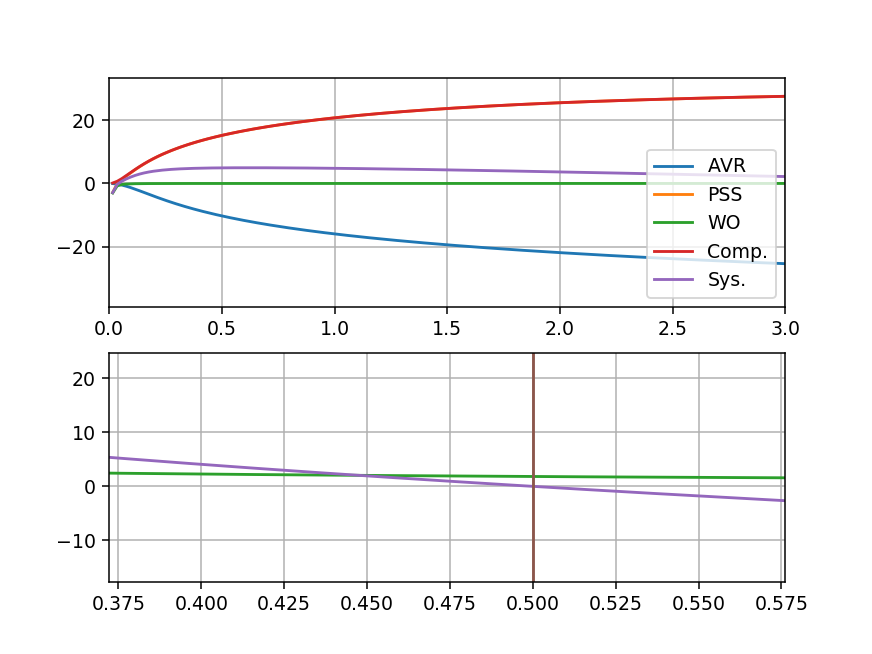

In [198]:
fig, axes = plt.subplots(nrows=2)
axes[0].plot(w_avr/(2*np.pi),mag_avr, label = 'AVR')
axes[1].plot(w_avr/(2*np.pi),phase_avr)

axes[0].plot(w_pss/(2*np.pi),mag_pss, label = 'PSS')
axes[1].plot(w_pss/(2*np.pi),phase_pss)

axes[0].plot(w_wo/(2*np.pi),mag_wo, label = 'WO')
axes[1].plot(w_wo/(2*np.pi),phase_wo)

axes[0].plot(w_lead/(2*np.pi),mag_lead, label = 'Comp.')
axes[1].plot(w_lead/(2*np.pi),phase_lead)

axes[0].plot(w_sys/(2*np.pi),mag_sys, label = 'Sys.')
axes[1].plot(w_sys/(2*np.pi),phase_sys)

axes[1].plot([freq,freq],[-90,90])


axes[0].grid()
axes[1].grid()

axes[0].set_xlim(0,3)
axes[1].set_xlim(0,3)
axes[1].set_ylim(-90,90)
axes[0].legend()

In [35]:
popt

array([-0.05634318,  0.58197132,  1.07779292])

In [27]:
a,T,w_m,sin_phi = sympy.symbols('a,T,w_m,sin_phi')

eq1 = w_m - 1/(T*sympy.sqrt(a))
eq2 = sin_phi - (a-1)/(a+1)

sol = sympy.solve([eq1,eq2],a,T)

In [205]:
avr_num = 1
model = 2
input_signal = 1 # omega
vs_max = 0.05
vs_min =-0.05
K_w = 100.0
T_w = T_wo
T_1_ = T_1[0]
T_2_ = T_2[0]
T_3 = 1
T_4 = 1
string = f'{avr_num}  {model}  {input_signal} '
string+= f'{vs_max}  {vs_min} {K_w} {T_w}  {T_1_} {T_2_}  {T_3}  {T_4} '
string+= f'25  0.5  0  0  0.045  0.045  0.045  -0.045  1  0.95  0  1;'


In [206]:
print(string)

1  2  1 0.05  -0.05 100.0 10.0  1.8383341178526476 0.05511576087196312  1  1 25  0.5  0  0  0.045  0.045  0.045  -0.045  1  0.95  0  1;
